Acknowledgements:
* Thank you to Kaggle members, Jagan and Anisotropic, for your notebook and detailed explanations. I learned a lot and owe this kernel to your teachings.


In [1]:
import time
start_time=time.time()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Proportion of train vs. test sets**

In [5]:
numrow_train=train.shape[0]
numrow_test=test.shape[0]
sum=numrow_train+numrow_test
print("       : train : test")
print("rows   :",numrow_train,":",numrow_test)
print("percnt :",round(numrow_train*100/sum),"   :",round(numrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
percnt : 51    : 49


**Proportion of toxic vs. clean comments**

In [6]:
x=train.iloc[:,2:].sum()

#marking comments without any tags
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

#count number of tags
train['clean'].sum()

print("Total comments: ", len(train))
print("Total % of Clean comments: ",round(((train['clean'].sum())/len(train))*100),"%")
print("Total % of Toxic comments: ",round(((len(train)-(train['clean'].sum()))/len(train))*100),"%")

Total comments:  159571
Total % of Clean comments:  90.0 %
Total % of Toxic comments:  10.0 %


**Amount of comments per category**

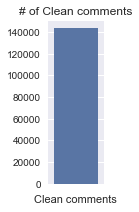

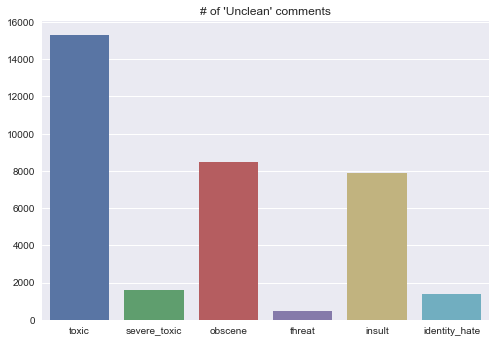

In [7]:
train['clean'] = train['clean'].astype(int) #convert boolean to numbers zero or one
x=train.iloc[:,2:].sum()                    #sum all rows

fig=plt.gcf()
fig.set_size_inches(1,3)
sns.barplot(x.values[6],orient='vertical')
plt.xlabel('Clean comments')
plt.title('# of Clean comments')
plt.show()

all_tags_but_clean = x.drop('clean')
sns.barplot(all_tags_but_clean.index, all_tags_but_clean.values)
plt.title('# of \'Unclean\' comments')
plt.show()

**Correlations between comments**


The strongest correlation is between Obscene & Insult


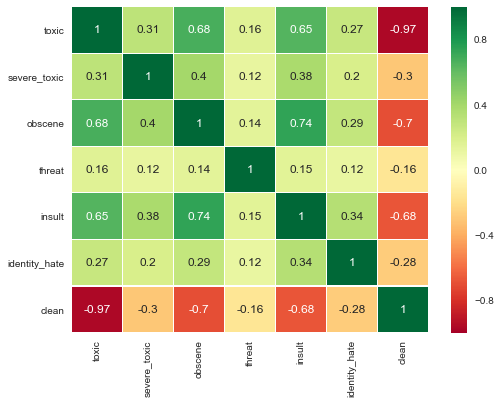

In [8]:
print("\nThe strongest correlation is between Obscene & Insult")
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #correlation matrix of our data
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.xticks(rotation=90)
plt.show()

# Comparing syntax

**Toxic comments**

In [9]:
toxic_comnts = train[train.toxic==1]['comment_text']
toxic_comnts = toxic_comnts[:1000]                                          # reduce comments size due to memory limitations
t_tokenized_sents = [word_tokenize(sentences) for sentences in toxic_comnts] # create sentences
t_tagged = [pos_tag(words) for words in t_tokenized_sents]                   # create tags for each token

In [10]:
t_categories = [y for lists in t_tagged for x,y in lists]                    # extract tags
t_counting_catg = Counter(t_categories)                                      # count tags

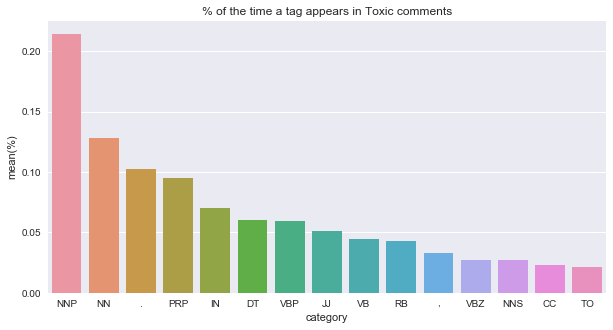

In [11]:
df = pd.DataFrame.from_dict(t_counting_catg, orient='index').reset_index()
df.columns=('category','amount')
df = df.sort_values(by='amount', ascending=False)
df = df[:15]                                                                 # limit to the top 15 highest counts of taggs
df['%'] = df['amount']/ df['amount'].sum(axis=0)                             # calculate percentage

sns.barplot(x='category', y='%', data=df)            
plt.title("% of the time a tag appears in Toxic comments")
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

****Clean comments****

In [12]:
clean_comnts = train[train.toxic==0]['comment_text']
clean_comnts = clean_comnts[:1000]                                           # reduce comments size due to memory limitations
tokenized_sents = [word_tokenize(sentences) for sentences in clean_comnts]
tagged = [pos_tag(words) for words in tokenized_sents] 

In [13]:
categories = [y for lists in tagged for x,y in lists]                     
counting_catg = Counter(categories)                            

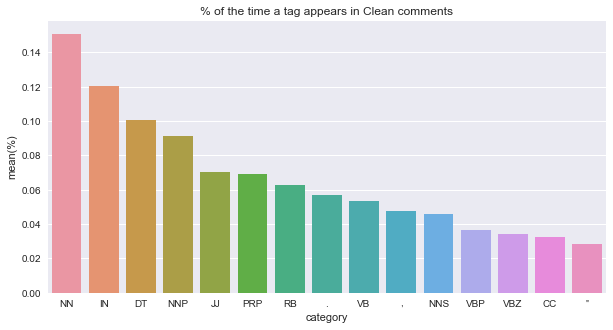

In [14]:
dfc = pd.DataFrame.from_dict(counting_catg, orient='index').reset_index()
dfc.columns=('category','amount')
dfc = dfc.sort_values(by='amount', ascending=False)
dfc = dfc[:15]                                                 
dfc['%'] = dfc['amount']/ dfc['amount'].sum(axis=0)            

sns.barplot(x='category', y='%', data=dfc)                     
plt.title("% of the time a tag appears in Clean comments")
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

* IN tag (preposition) appears 12.0% of the times in Clean comments as opposed to 7.5% in Toxic
* '.' tag (a period) appears 6.0% of the times in Clean comments as opposed to 12.5% in Toxic
* NNP (proper noun) appears 8.5% of the times in Clean comments as opposed to 18.5% in Toxic

**We can use these differences later on to see if they help the model predict the correct category**

In [15]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

# Comparing vocabulary usage

**Toxic comments**

In [16]:
# Word-tokenize all toxic comments
tknzr = TweetTokenizer()
t_sentences = [sent_tokenize(s) for s in toxic_comnts]
t_lists_of_words = [tknzr.tokenize(words) for strings in t_sentences for words in strings]

# Keep only letters (remove special characters and digits) 
t_only_letters = [regexp_tokenize(token, pattern='[a-zA-Z]+') for sublist in t_lists_of_words for token in sublist]

# Flatten list of lists
t_flat_list = [token for sublist in t_only_letters for token in sublist]

# Lowercase all words
t_all_lower = [l.lower() for l in t_flat_list]

# Remove stop words
stopWords = set(stopwords.words('english'))
t_no_stpwrds = [token for token in t_all_lower if token not in stopWords]

# Count words and list most common ones
commonly_toxic = Counter(t_no_stpwrds)

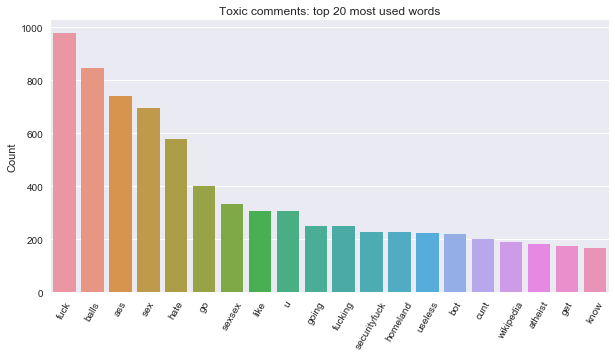

In [17]:
wording, counting = zip(*commonly_toxic.most_common(n=20))
sns.barplot(x=wording, y=counting)
plt.xticks(rotation=60)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.title("Toxic comments: top 20 most used words")
plt.ylabel('Count')
plt.show()

**Clean comments**

In [18]:
# Word-tokenize clean comments
tknzr = TweetTokenizer()
sentences = [sent_tokenize(s) for s in clean_comnts]
lists_of_words = [tknzr.tokenize(words) for strings in sentences for words in strings]

# Keep only letters (remove special characters and digits) 
only_letters = [regexp_tokenize(token, pattern='[a-zA-Z]+') for sublist in lists_of_words for token in sublist]

# Flatten list of lists
flat_list = [token for sublist in only_letters for token in sublist]

# Lowercase all words
all_lower = [l.lower() for l in flat_list]

# Remove stop words
stopWords = set(stopwords.words('english'))
no_stpwrds = [token for token in all_lower if token not in stopWords]

#Count words and list most common ones
commonly_clean = Counter(no_stpwrds)

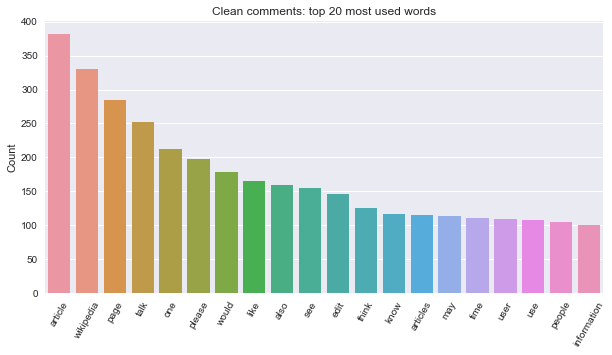

In [19]:
words, count = zip(*commonly_clean.most_common(n=20))
sns.barplot(x=words, y=count)
plt.xticks(rotation=60)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.title("Clean comments: top 20 most used words")
plt.ylabel('Count')
plt.show()

* We can see a big difference in vocabulary between the top words in clean and toxic comments

# WordCloud 
* For toxic comments

In [681]:
from wordcloud import WordCloud

# Convert list of words into one long string for WordCloud to read
toxicity = ' '.join(t_no_stpwrds)

#0 rel_scaling= only word-ranks are considered; 1 rel_scaling = a word that is twice as frequent will have twice the size
#min font size = anything smaller than integer won't go in wordcloud
wordcloud2 = WordCloud(collocations=False, relative_scaling=1, min_font_size=13,width=400, height=200)
wordcloud2.generate(toxicity)
plt.figure(figsize=(16,7))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Toxic WordCloud')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

* For Clean comments

In [ ]:
clean = ' '.join(no_stpwrds)

#0 rel_scaling= only word-ranks are considered; 1 rel_scaling = a word that is twice as frequent will have twice the size
#min font size = anything smaller than integer won't go in wordcloud
wordcloud2 = WordCloud(collocations=False, relative_scaling=1, min_font_size=13,width=400, height=200)
wordcloud2.generate(clean)
plt.figure(figsize=(16,7))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Clean WordCloud')
plt.show()

# Trolling

* Trolls go out of their way to enrage others with their biased opinion, with the goal of getting a response back.
* Many trolls tend to repeat words. So, we'll use n_grams & frecuency filters to find these words

In [20]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

Here are 50 trigrams (3 consecutive words) that each appear over 40 times in toxic comments: **A strong indicator of trolling!**

In [21]:
# Trigrams
finder = TrigramCollocationFinder.from_words(t_no_stpwrds)

# only trigrams that appear 40+ times
finder.apply_freq_filter(40)
 
# return the 50 trigrams with the highest PMI
print (finder.nbest(trigram_measures.pmi, 50))

[('asian', 'american', 'scum'), ('scum', 'piece', 'asian'), ('piece', 'asian', 'american'), ('american', 'scum', 'piece'), ('lion', 'king', 'bestfrozen'), ('bestfrozen', 'sucks', 'lion'), ('king', 'bestfrozen', 'sucks'), ('sucks', 'lion', 'king'), ('mothjer', 'fucker', 'cocksucker'), ('cocksucker', 'mothjer', 'fucker'), ('fucker', 'cocksucker', 'mothjer'), ('romney', 'user', 'enigmaman'), ('fggt', 'know', 'fggt'), ('mitt', 'romney', 'user'), ('romney', 'user', 'nhrhs'), ('user', 'enigmaman', 'homo'), ('user', 'nhrhs', 'homo'), ('penis', 'penis', 'penis'), ('like', 'mitt', 'romney'), ('enigmaman', 'homo', 'like'), ('nhrhs', 'homo', 'like'), ('homo', 'like', 'mitt'), ('know', 'fggt', 'know'), ('kill', 'going', 'murder'), ('murder', 'going', 'kill'), ('njgw', 'fucking', 'loser'), ('homeland', 'securityfuck', 'homeland'), ('securityfuck', 'homeland', 'securityfuck'), ('fucking', 'loser', 'bastard'), ('going', 'murder', 'going'), ('u', 'useless', 'bot'), ('going', 'kill', 'going'), ('shut',

# Spam

* One aspect of Spam is repetition. When looking at the context of words, we might detect Spam

In [22]:
ttoxic = nltk.Text(t_no_stpwrds)
print (ttoxic.concordance('homeland', 54, lines=10))

Displaying 10 of 227 matches:
nt belive securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
 homeland securityfuck homeland securityfuck homeland 
None


* A strong sign of outliers is when you have a big difference between the mean and the median

In [23]:
severe_tox = train[train['severe_toxic']==1]['comment_text']
print("Mean average length of characters in severly toxic comments:", round(severe_tox.map(lambda x: len(x)).mean()))
print("Median average length of characters in severly toxic comments:",round(severe_tox.map(lambda x: len(x)).median()))

Mean average length of characters in severly toxic comments: 454
Median average length of characters in severly toxic comments: 94


* The Outliers are most likely our spam. Let's confirm.

In [24]:
# A few severe toxic comments and their length
severe_tox.map(lambda x: len(x))[20:26]

2055     140
2094      97
2217      43
2227     157
2243     182
2249    2885
Name: comment_text, dtype: int64

* Comment 2249 is much longer than the average legth of characters. Let's look into it.

In [25]:
print(severe_tox[2249])

YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! Y

* Et voila!

# Feature Characteristics

**Unique words in each comment category**

In [26]:
train['uniq_word']=train['comment_text'].apply(lambda x: len(set(str(x).split())))

In [27]:
cl1 = train.loc[train['clean']==1]['uniq_word'].median()
sev1 = train.loc[train['severe_toxic']==1]['uniq_word'].median()
tox1 = train.loc[train['toxic']==1]['uniq_word'].median()
ob1 = train.loc[train['obscene']==1]['uniq_word'].median()
thrt1 = train.loc[train['threat']==1]['uniq_word'].median()
insl1 = train.loc[train['insult']==1]['uniq_word'].median()
ih1 = train.loc[train['identity_hate']==1]['uniq_word'].median()

cag_uniq = [cl1,sev1,tox1,ob1,thrt1,insl1,ih1]

*Not surprising how severely toxic comments have very limited vocabulary.

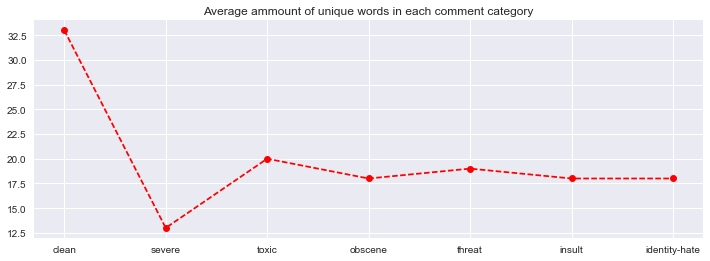

In [28]:
labels=['clean','severe','toxic','obscene','threat','insult','identity-hate']
order_of_labels = range(len(cag_uniq))

plt.figure(figsize=(12,4))
plt.plot(cag_uniq, 'r--', marker='o')
plt.xticks(order_of_labels, labels)
plt.title('Average ammount of unique words in each comment category')
plt.show()

**Amount of Punctuation in each comment category**

In [29]:
import string
train['punc_len'] = train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [30]:
c2 = train.loc[train['clean']==1]['punc_len'].median()
s2 = train.loc[train['severe_toxic']==1]['punc_len'].median()
t2 = train.loc[train['toxic']==1]['punc_len'].median()
ob2 = train.loc[train['obscene']==1]['punc_len'].median()
th2 = train.loc[train['threat']==1]['punc_len'].median()
ins2 = train.loc[train['insult']==1]['punc_len'].median()
ih2 = train.loc[train['identity_hate']==1]['punc_len'].median()

cat2 = [c2,s2,t2,ob2,th2,ins2,ih2]

* As expected, clean comments tend to use more punctuation

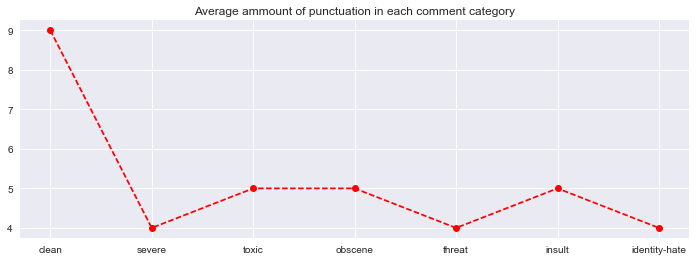

In [31]:
labels=['clean','severe','toxic','obscene','threat','insult','identity-hate']
order_of_labels = range(len(cat2))

plt.figure(figsize=(12,4))
plt.plot(cat2, 'r--', marker='o')
plt.xticks(order_of_labels, labels)
plt.title('Average ammount of punctuation in each comment category')
plt.show()

**Amount of Personal Pronoun (I)**

In [32]:
train['len_I'] = train['comment_text'].apply(lambda x: len(re.findall(r"(\s+-?I\s)|(\s[iI]'m\s)|(\si\s)|(\s[iI]'d\s)|((\s[iI]'ve\s)|((\s[iI]'ll\s)))", str(x))))

In [33]:
CL = train.loc[train['clean']==1]['len_I'].mean()
SV = train.loc[train['severe_toxic']==1]['len_I'].mean()
TO = train.loc[train['toxic']==1]['len_I'].mean()
INS = train.loc[train['insult']==1]['len_I'].mean()
TH = train.loc[train['threat']==1]['len_I'].mean()
OB = train.loc[train['obscene']==1]['len_I'].mean()
IH = train.loc[train['identity_hate']==1]['len_I'].mean()

c_list = [CL, SV, TO, INS, TH, OB, IH]

* Threatening comments seem to have a highly personal context

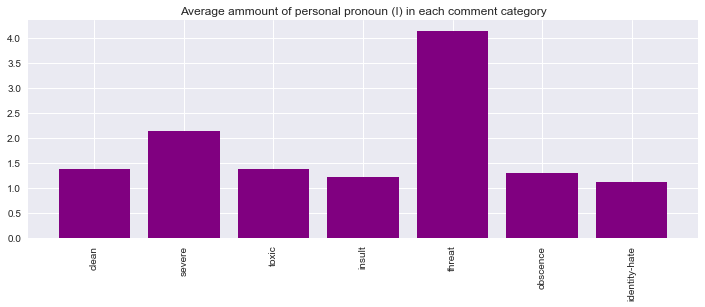

In [34]:
labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(left=order_of_labels ,height=c_list, color='purple')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average ammount of personal pronoun (I) in each comment category')
plt.show()

**Future Tense usages**

In [35]:
train['len_will'] = train['comment_text'].apply(lambda x: len(re.findall(r"\s[wW]ill|[Iiuey]'ll|gonna", str(x))))

In [36]:
c = train[train['clean']==1]
CLEAN = len(c[c['len_will']>0]) / len(c)

s = train[train['severe_toxic']==1]
SEVERE = len(s[s['len_will']>0]) / len(s)

t = train[train['toxic']==1]
TOXIC = len(t[t['len_will']>0]) / len(t)

i = train[train['insult']==1]
INSULT = len(i[i['len_will']>0]) / len(i)

thr = train[train['threat']==1]
THREAT = len(thr[thr['len_will']>0]) / len(thr)

o = train[train['obscene']==1]
OBSCENE = len(o[o['len_will']>0]) / len(o)

ith = train[train['identity_hate']==1]
IDENTITY = len(ith[ith['len_will']>0]) / len(ith)

In [37]:
cag = [CLEAN,SEVERE,TOXIC,INSULT,THREAT,OBSCENE,IDENTITY]

* Apparently, the future tense is used in threating comments more than in any other category 

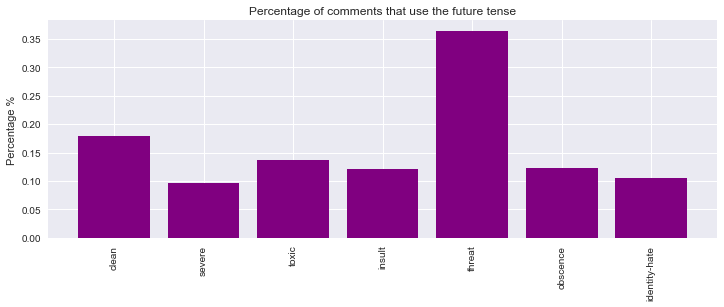

In [38]:
labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(cag))

plt.figure(figsize=(12,4))
plt.bar(left=order_of_labels ,height=cag, color='purple')
plt.xticks(order_of_labels, labels, rotation=90)
plt.ylabel('Percentage %')
plt.title('Percentage of comments that use the future tense')
plt.show()

# Cleaning Corpus for Vectorization

In [39]:
sample = train.copy()

In [40]:
for comments in train,test:
    # remove '\\n'
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
    # remove any text starting with User... 
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
    # remove IP addresses or user IDs
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
    # lower uppercase letters
    comments['comment_text'] = comments['comment_text'].map(lambda x: str(x).lower())
    
    #remove http links in the text
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))
    
    #remove all punctuation except for apostrophe (')
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','',str(x)))


* Let's see an example of a comment before and after cleaning

In [41]:
print("**Before:**\n")
print (sample['comment_text'][73])

**Before:**

"
 Ambiguous ? 
So Mabuska Irish can mean more than one thing ? I will qoute you on that .Thanks .  — Preceding unsigned comment added by 109.77.58.139   
Of course it can. The word ""Irish"" wasn't invented on the establishment of the Irish Free State. Talk 

Quote me all you want, it depends on the context of the term when its being used as to whether its applicable or not. Note how i said citizenship and ethnicity - i never mentioned nationality which is the real key meaning. The nationality meaning of the term is the predominantly used form on Wikipedia. In nationality terms it refers to the Republic of Ireland. But you already know that i'm sure.  (talk) 

""In nationality terms it refers to the Republic of Ireland"" no such country . so nationality terms it refers to Ireland .  — Preceding unsigned comment added by 109.76.191.188   

Oh wow, Ireland as in Ireland the state (whose official description is the Republic of Ireland). Whats the point in this inane conversa

In [42]:
print("**After:**\n")
print(train['comment_text'][73])

**After:**

  ambiguous   so mabuska irish can mean more than one thing  i will qoute you on that thanks   — preceding unsigned comment added by     of course it can the word irish wasn't invented on the establishment of the irish free state talk   quote me all you want it depends on the context of the term when its being used as to whether its applicable or not note how i said citizenship and ethnicity  i never mentioned nationality which is the real key meaning the nationality meaning of the term is the predominantly used form on wikipedia in nationality terms it refers to the republic of ireland but you already know that i'm sure  talk   in nationality terms it refers to the republic of ireland no such country  so nationality terms it refers to ireland   — preceding unsigned comment added by      oh wow ireland as in ireland the state whose official description is the republic of ireland whats the point in this inane conversation  talk   ireland whose official name is ireland   — pr

In [43]:
end_time=time.time()
print("total time",end_time-start_time)

total time 455.15734124183655


# To Be Continued... 
* Building our Vectors and Classifiers